## Step 1 - The set up.

Import the necessary libraries for the model

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

import keras

from tensorflow import keras
from keras import layers, models
from keras.models import Sequential
from keras.metrics import Precision, Recall


from keras.optimizers import SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras.applications import MobileNetV2
from keras.callbacks import EarlyStopping, LearningRateScheduler




In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Step 2 - Load the data

This step involves efficiently loading image data from disk using the `tf.keras.utils.image_dataset_from_directory` utility. This method allows us to directly create a `tf.data.Dataset` object, streamlining the process of handling images for training. In this specific case, we've diverged from the original tutorial by employing a different dataset, yet the fundamental approach remains unchanged. The images are organized into `train_data` and `validation_data`, the latter being crucial for fine-tuning the model during its training phase. Unlike the tutorial, we also incorporate a `test_data` set, reflecting the CIFAKE dataset's clear segmentation into training and testing subsets. 

We've adjusted the batch size to 128 from the initially smaller size of 32. This alteration is grounded in the principle that a larger batch size can facilitate a more stable convergence during the training process. The reason behind this is that gradient estimates based on larger batches tend to exhibit reduced variance, thereby making each update more reflective of the overall dataset. Opting for a batch size of 128 is a strategic choice aimed at enhancing the robustness and effectiveness of the learning algorithm in TensorFlow projects.




In [5]:
train_data_dir = 'C:/Users/Test1/Desktop/Datavetenskap/YEAR3/ImageRecognition/Res/train'
test_data_dir = 'C:/Users/Test1/Desktop/Datavetenskap/YEAR3/ImageRecognition/Res/test'

image_height = 32
image_width = 32
batch_size = 128

train_data = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    batch_size=batch_size ,
    image_size=(image_height, image_width)
)

validation_data = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    batch_size=batch_size ,
    image_size=(image_height, image_width)
)

test_data = tf.keras.utils.image_dataset_from_directory(
    test_data_dir,
    seed=123,
    batch_size=batch_size ,
    image_size=(image_height, image_width)
)

class_names = train_data.class_names
print("\nData consists of " + str(len(class_names)) + " classes:", class_names)

KeyboardInterrupt: 

## Step 3 - vizualise the data

This section displays the first nine images from the dataset.

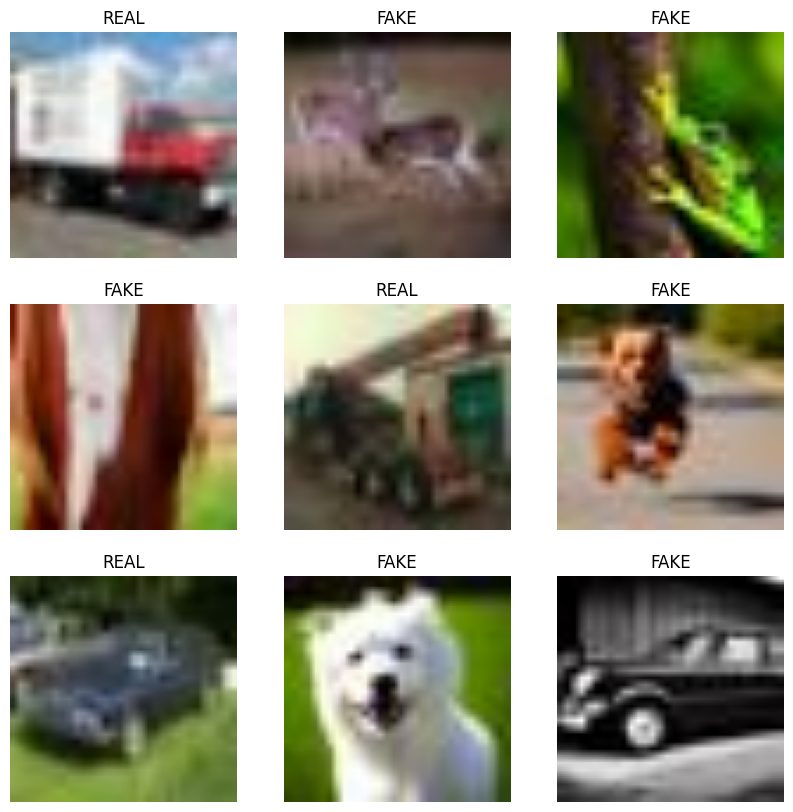

In [ ]:

def show_images(dataset, class_names, num_images=5):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(num_images):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")

show_images(train_data, class_names, num_images=9)


## Step 4 Configure the dataset for performance

The tutorial now discusses optimizing data loading during model training to prevent I/O operations from becoming a bottleneck. It introduces two key methods. The `Dataset.cache` method is recommended for keeping images in memory after their initial load from the disk during the first epoch of training. It helps ensure that the dataset does not slow down model training. For datasets too large to fit in memory, it suggests creating an on-disk cache to maintain performance.

The `Dataset.prefetch` method is used to overlap data preprocessing with model execution during training, improving efficiency by ensuring the training process doesn't wait for these operations to complete sequentially.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = validation_data.cache().prefetch(buffer_size=AUTOTUNE)

## Step 5 - Create the basic Keras model

The model uses a `Sequential` approach, beginning with a `Rescaling` layer to normalize image pixel values from 0 to 255 down to a range of 0 to 1, enhancing model convergence during training. The input images are expected to have a size defined by `image_height` and `image_width`, with three color channels (RGB).

The core of the model consists of three convolutional layers with increasing numbers of filters (16, 32, and 64), each followed by a max pooling layer to reduce spatial dimensions and computation, thus enhancing feature extraction. A `Flatten` layer then converts 3D feature maps into 1D feature vectors, preparing the data for the fully connected layers.

The network includes two dense layers for further processing; the first has 128 neurons with ReLU activation, while the final layer corresponds to the number of classes in the dataset. The output layer's activation function is implied to be linear, suitable for use with loss functions like `SparseCategoricalCrossentropy` with `from_logits=True`, eliminating the need for a softmax activation function in multi-class classification tasks.

In [ ]:
num_classes = len(class_names)

model = models.Sequential([
  layers.Rescaling(1./255, input_shape=(image_height, image_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

C:\Users\Test1\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Step 5 - Compile the model
The tutorial employs the `tf.keras.optimizers.Adam` optimizer along with the `tf.keras.losses.SparseCategoricalCrossentropy` loss function. It exclusively relies on the accuracy metric to evaluate performance after each training epoch. This research, however, has opted to include recall and precision measurements as well, providing a more detailed insight into the model's performance.


In [ ]:
model.compile(optimizer= 'Adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy', Precision(), Recall()])

In [ ]:
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 96, 96, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 48, 48, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 48, 48, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │     1,179,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,203,618 (4.59 MB)

 Trainable params: 1,203,618 (4.59 MB)

 Non-trainable params: 0 (0.00 B)

## Step 6 - Train the model 

The tutorial utilizes the Keras function model.fit to train the model across 10 epochs.

the model's training and validation results show a consistent improvement in accuracy and a decrease in loss over the 10 epochs, indicating successful learning. Starting with an accuracy of 79.71% and a loss of 0.4202 in the first epoch, the model's accuracy increased to 95.99% with a loss of 0.1021 by the 10th epoch on the training data. The validation accuracy and loss also improved over time, starting from 84.35% accuracy and a 0.3692 loss in the first epoch, to reaching 93.76% accuracy with a 0.1626 loss by the 10th epoch. This suggests that the model is generalizing well to new data, not seen during the training process. 

In [ ]:

epochs = 10
# history = model.fit(
#   train_ds,
#   validation_data=val_ds,
#   epochs=epochs
# )

The final test accuracy achieved was 93.69% with a loss of 0.1636, which is slightly lower than the best validation accuracy but still indicates a high level of performance even without any finetuning implemented.  

In [ ]:
# Evaluate the model on the test dataset
# test_loss, test_acc = model.evaluate(test_data)
# print('\nTest accuracy:', test_acc)

## Step 7 - Visualize training results

Creating plots to visualize the accuracy on both the training and validation sets offers a clearer understanding of how accuracy evolves across epochs. Interestingly, in the TensorFlow tutorial, there's a significant discrepancy between the training and validation accuracies, with the model reaching close to 60% accuracy on the validation set and nearly 99% on the training set. This considerable gap is indicative of overfitting, where the model is overly specialized to the training data, impairing its ability to generalize to new, unseen data. Our model, however, doesn't exhibit the same extent of overfitting as observed in the tutorial.


In [ ]:
# import matplotlib.pyplot as plt

# # Extract accuracy and loss from the history object
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']
# loss = history.history['loss']
# val_loss = history.history['val_loss']

# # Generate a range object for the number of epochs
# epochs_range = range(epochs)

# # Plotting
# plt.figure(figsize=(16, 8))  # Set the figure size for better readability
# plt.subplot(1, 2, 1)  # Define the first subplot
# plt.plot(epochs_range, acc, label='Training Accuracy')  # Plot training accuracy
# plt.plot(epochs_range, val_acc, label='Validation Accuracy')  # Plot validation accuracy
# plt.legend(loc='lower right')  # Place the legend in the lower right corner
# plt.title('Training and Validation Accuracy')  # Title for the first subplot

# plt.subplot(1, 2, 2)  # Define the second subplot
# plt.plot(epochs_range, loss, label='Training Loss')  # Plot training loss
# plt.plot(epochs_range, val_loss, label='Validation Loss')  # Plot validation loss
# plt.legend(loc='upper right')  # Place the legend in the upper right corner
# plt.title('Training and Validation Loss')  # Title for the second subplot
# plt.show()  # Display the plots


In [ ]:

from keras.applications import MobileNetV2
from keras.callbacks import EarlyStopping, LearningRateScheduler
from keras.optimizers import Adam

data_augmentation = keras.Sequential([
  layers.RandomFlip('horizontal'),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
])

base_model = MobileNetV2(input_shape=(image_height, image_width, 3),
  include_top=False,
  weights='imagenet')
base_model.trainable = False 

model = models.Sequential([
  data_augmentation,
  base_model,
  layers.GlobalAveragePooling2D(),
  layers.Dropout(0.2), 
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer=Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3)

def scheduler(epoch, lr):
  if epoch < 10:
    return float(lr)
  else:
    return float(lr * tf.math.exp(-0.1))
lr_scheduler = LearningRateScheduler(scheduler)

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[early_stopping, lr_scheduler]
)

test_loss, test_acc, test_precision, test_recall = model.evaluate(test_data)
print('\nTest accuracy:', test_acc)
print('Test precision:', test_precision)
print('Test recall:', test_recall)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10
516/625 ━━━━━━━━━━━━━━━━━━━━ 47s 438ms/step - accuracy: 0.6609 - loss: 0.6371

KeyboardInterrupt: 